# Task 2

1. General Analysis 
<br>&nbsp;a. Distribution of estimated coefficients and residuals 
<br>&nbsp;&nbsp;(i) 1 covariate 
<br>&nbsp;&nbsp;(ii) 3 covariate 

2. Outliers 
<br>&nbsp;a. Number of Outliers
<br>&nbsp;b. Magnitude of Outliers
<br>&nbsp;c. Detecting Outliers
<br>&nbsp;&nbsp;(i) Overview - using influence plots
<br>&nbsp;&nbsp;(ii) Using y-residual graphs 
<br>&nbsp;&nbsp;(iii) Using fitted-vs-residuals plots 
<br>&nbsp;d. Effect of outliers on normalization of covariates

3. Multicollinearity
<br>&nbsp;a.Effect of coefficient estimation
<br>&nbsp;b.Using the Varaince Inflation Factor 
<br>&nbsp;c.Handling multicollinearity 
<br>&nbsp;&nbsp;(i) eliminating hihgly correlated variable 
<br>&nbsp;&nbsp;(ii) create independent covariates using residuals of a prediction model 
<br>&nbsp;&nbsp;(iii) using PCA to find uncorrelated covariates for regression 

In [23]:
import numpy as np
import pandas as pd
import math
import random 
from scipy import stats
from numpy.random import default_rng


# We will use matplotlib to plot figures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()

from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.preprocessing import Normalizer

# For regression analysis we will use the statsmodels package
import statsmodels.formula.api as sm
import statsmodels.tools.eval_measures as sme 
from statsmodels.tools.eval_measures import rmse

# For visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

In [24]:
#import helper function
%run helper_functions_t2.py

<Figure size 432x288 with 0 Axes>

In [25]:
LINE_PARAMETERS = [7,8,9]
rng = default_rng()

# General Analysis

In [26]:
NUMBER_OF_SAMPLES = 100
SEED = 1028

### Distribution of estimated coefficients and residuals

### 1 covariate


OLS model parameters:
Intercept: -0.23714, Intercept SE: 0.21402
x1 coef: 7.01999, x1 coef SE: 0.03603

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 2.118, Root Mean Squared Error: 2.107


(-2.1671553440683055e-15, 2.117885281492145, 2.107269248317702)

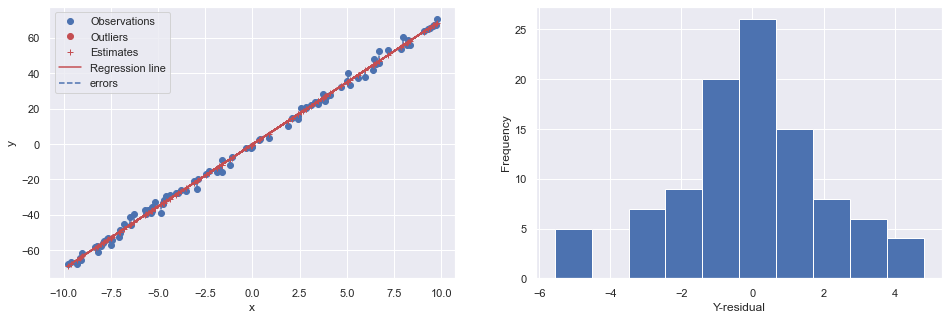

In [27]:
#generate data  
data = generate_data(1, [-10], [10], 0, 2, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data)

#Model Evaluation
eval_ols_model(data)

**LHS: This graphs plots the actual and estimated data points for the observed and OLS data model. Based on the parameter values generated by the model, we note that the slope and intercept model very closely correspond with the parameters of the true model. The OLS model produced a slope value of 6.989 with a standard error of 0.0354. As the actual value of the slope parameter is 7, we note that the true value falls within the error margin of the slope parameter from the model. 
<br><br> RHS:By inspecting the histogram of the y-residuals, we observe that it follows a normal distribution with a mean roughly equal to 0 and a standard deviation roughly equal to 2 (see output below). This is true to the noise variable injected to the model which also follows a normal distribution with a mean = 0 and standard deviation = 2.**

## 3 covariates


OLS model parameters:
Intercept: -3.29592, Intercept SE: 3.21072
x1 coef: 16.64205, x1 coef SE: 11.09876
x2 coef: 7.96392, x2 coef SE: 0.10712
x3 coef: 8.98364, x3 coef SE: 0.01113

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 31.392, Root Mean Squared Error: 31.235


(-1.6370904631912708e-13, 31.39244725050756, 31.235090634287268)

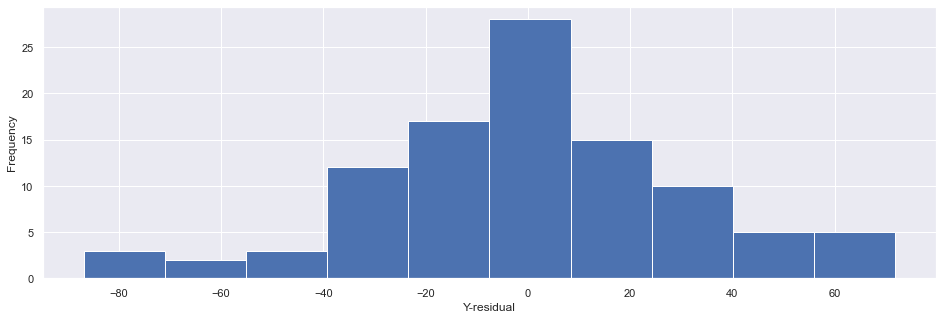

In [28]:
#generate data  
data = generate_data(3, [-0.5, -50, -500], [0.5, 50, 500], 0, 30, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 3, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot y-residuals
fig = plt.figure(figsize=(16,5))                                  
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')

#Model Evaluation
eval_ols_model(data)

**In this model, we observe the performance of an OLS model when the scales of the covariates vary and a non negligible noise factor is injected to the true model. First we note that:**
    <br> **(i) x2 is 2 orders of magnitude larger than x1**
    <br> **(ii) x3 is 1 order of magnitude larger than x2**
    <br> **(iii) epsilon (noise) is the same order of magnitude as x2**
    <br>**Once the least squares model is fit, we note than the parameter values for x2 and x3 closely correspond with that of the true model, (8 and 9 respectively) with a relatively small error margin. The coefficient of covariate x1 is roughly 11 with a standard error  of 11, whereas the value in the true model is 7. This can be interpreted as the coefficient of covariate x1 is fit to model a larger proportion of the noise than the reamaining covariates' coefficients. Nonetheless, we note that the model has good performance by observing the y-residuals graph which shows a mean of roughly 0 and a standard error of (roughly) 32 which closely corresponds with the noise factor injected in the true model.**

# Outliers

**To study effects outliers on linear regression, a single covariate was used to allow for visual representation of the outliers in 2D graph**

In [29]:
NUMBER_OF_SAMPLES = 25

## Number of outliers

**In this section, we observe the effects of introducing a specific percentage of the datapoints as outliers. The maximum percentage of outliers being studied is 30% as with values higher than this, the model may not be a good candidate for linear regression. Here we define an outlier as a data point that deviates anywhere between 0 to 4 times the expected y-value of the true model. Also note that the scale factor for each outlier is chosen at random.  each iteration of a specific percentage of outliers is run 5 times to ensure results can be reproduced.**

In [30]:
perc_outliers = np.arange(1,31, 1) 

results_df = pd.DataFrame(columns=['%Outliers', 'Coefficient', 'Coefficient_SE', 'Intercept', 'Intercept_SE', 'RMSE'])

for val in perc_outliers:
    for i in range(0,10):
        #generate random data + add % of outliers 
        data = generate_data(1, [-10], [10], 2, 5, NUMBER_OF_SAMPLES)
        data['y'] = calculate_y(data, 1, LINE_PARAMETERS)
        data = add_outliers(data, val, 0, 4)
        #fit using an ols model 
        result = sm.ols(formula='y ~ x1', data=data).fit()
        #calculate estimated and residual values,rmse
        data['y_est'] = calculate_y_est(data, result)
        data['residuals'] = data['y_est'] - data['y']
        rmse = np.sqrt(metrics.mean_squared_error(data.y, data.y_est))

        #add result to df 
        new_result = {'%Outliers': round(val), 'Coefficient' : result.params[1], 'Coefficient_SE': result.bse[1], 'Intercept': result.params[0], 
                              'Intercept_SE': result.params[0], 'RMSE': rmse}
        results_df = results_df.append(new_result, ignore_index = True)
    
#calculate average across all iterations
results_df = results_df.groupby(['%Outliers']).mean().reset_index()
#calculate error in coefficient estimation
results_df['Coefficient_Error%'] = (abs(results_df['Coefficient']-LINE_PARAMETERS[0])/LINE_PARAMETERS[0])*100

results_df.head()

,%Outliers,Coefficient,Coefficient_SE,Intercept,Intercept_SE,RMSE,Coefficient_Error%
0,1.0,6.986434,0.165928,2.305411,2.305411,4.579710,0.193803
1,2.0,7.205053,0.319887,2.414694,2.414694,8.530985,2.929334
2,3.0,7.592988,0.529651,2.651585,2.651585,14.652872,8.471259
3,4.0,7.784527,0.511572,-1.047809,-1.047809,14.477452,11.207529
4,5.0,7.680349,0.528707,2.168498,2.168498,12.915105,9.719269


Text(0.5, 1.0, 'Coefficient value vs. % Outliers')

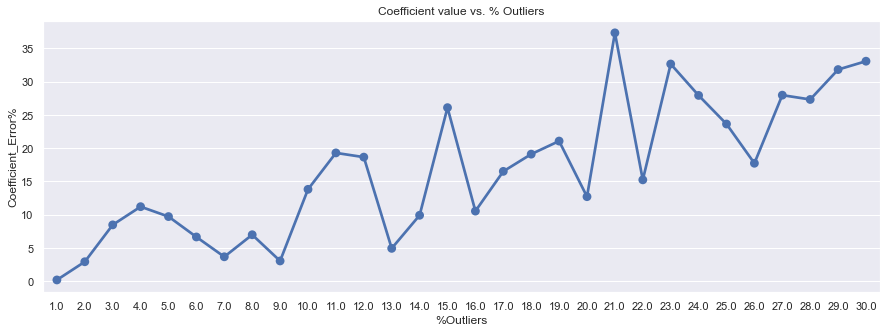

In [31]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="%Outliers", y="Coefficient_Error%", data=results_df)
ax.set_title('Coefficient value vs. % Outliers')

Text(0.5, 1.0, 'RMSE vs. % Outliers')

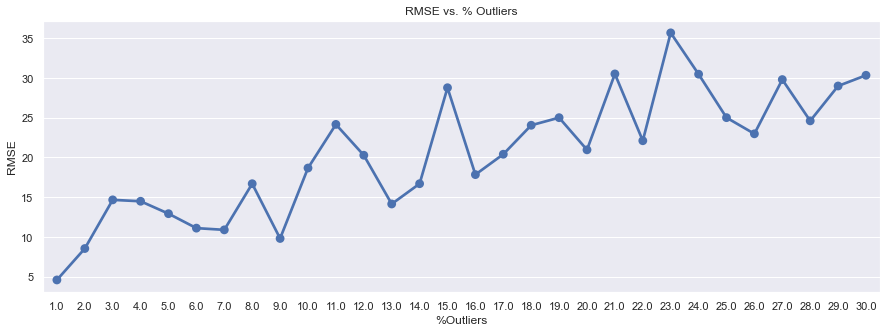

In [32]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="%Outliers", y="RMSE", data=results_df)
ax.set_title('RMSE vs. % Outliers')

### add explanation -------------------------------------------------------------------------------------------------------------------------------------
linear relationship between percentage of outliers + parameter estimation - calculate error percentage 
model rmse 
draw error bars or if another more helpful ? 

## Magnitude of outliers

In [33]:
max_scale_factor = np.arange(-2,4, 0.5)

results_df = pd.DataFrame(columns=['Outlier_Mag', 'Coefficient', 'Coefficient_SE', 'Intercept', 'Intercept_SE','RMSE'])


for val in max_scale_factor:
    for i in range(0,10):
        #generate random data + add % of outliers 
        data = generate_data(1, [-10], [10], 2, 5, NUMBER_OF_SAMPLES)
        data['y'] = calculate_y(data, 1, LINE_PARAMETERS)
        data = scale_datapoints(data, 10, val) #scale 10% of datapoint
        #fit using an ols model 
        result = sm.ols(formula='y ~ x1', data=data).fit()
        #calculate estimated and residual values,rmse
        data['y_est'] = calculate_y_est(data, result)
        data['residuals'] = data['y_est'] - data['y']
        rmse = np.sqrt(metrics.mean_squared_error(data.y, data.y_est))

        #add result to df 
        new_result = {'Outlier_Mag': val, 'Coefficient' : result.params[1], 'Coefficient_SE': result.bse[1], 'Intercept': result.params[0], 
                              'Intercept_SE': result.params[0], 'RMSE': rmse}
        results_df = results_df.append(new_result, ignore_index = True)
    
#calculate average across all iterations
results_df = results_df.groupby(['Outlier_Mag']).mean().reset_index()
#calculate error in coefficient estimation
results_df['Coefficient_Error%'] = (abs(results_df['Coefficient']-LINE_PARAMETERS[0])/LINE_PARAMETERS[0])*100

results_df.head()

,Outlier_Mag,Coefficient,Coefficient_SE,Intercept,Intercept_SE,RMSE,Coefficient_Error%
0,-2.0,4.634216,1.376545,-1.096072,-1.096072,36.428634,33.796909
1,-1.5,5.074740,1.125808,-0.238674,-0.238674,30.824818,27.503715
2,-1.0,5.325202,0.918571,0.277096,0.277096,24.136249,23.925681
3,-0.5,5.493239,0.745293,3.467318,3.467318,20.484695,21.525164
4,0.0,6.424631,0.425555,1.914474,1.914474,12.057456,8.219553


Text(0.5, 1.0, 'Coefficient Estimation Error Percentage vs. Magnitude of Outliers')

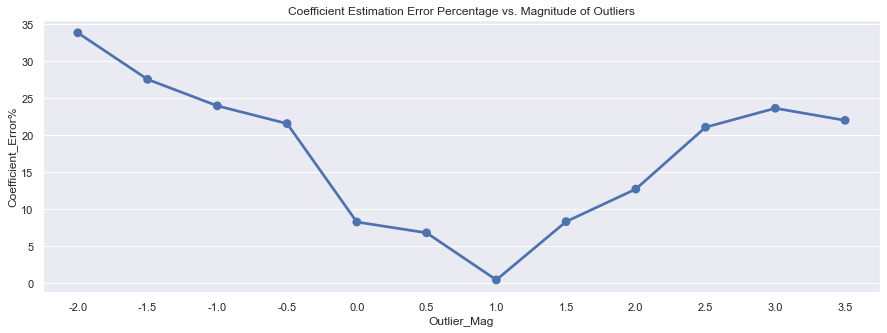

In [34]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="Outlier_Mag", y="Coefficient_Error%", data=results_df)
ax.set_title('Coefficient Estimation Error Percentage vs. Magnitude of Outliers')

Text(0.5, 1.0, 'RMSE vs.  Magnitude of Outliers')

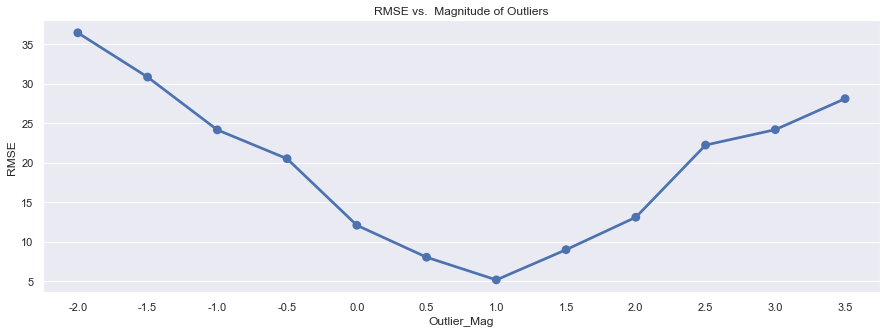

In [35]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="Outlier_Mag", y="RMSE", data=results_df)
ax.set_title('RMSE vs.  Magnitude of Outliers')

### add explanation -------------------------------------------------------------------------------------------------------------------------------------
discuss why graph is parabolic/symmetric around 1?


## Detecting Outliers

**In this section, various tools to detect outliers in a data model are studied. Furthermore, a methods to find outliers in the covariate and noise variables are also discussed.** 

In [36]:
# fix the generator to a seed
SEED = 28
NUMBER_OF_SAMPLES = 50

**Baseline Model without outliers**


OLS model parameters:
Intercept: -0.02042, Intercept SE: 0.2911
x1 coef: 7.01128, x1 coef SE: 0.049

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 1.982, Root Mean Squared Error: 1.962


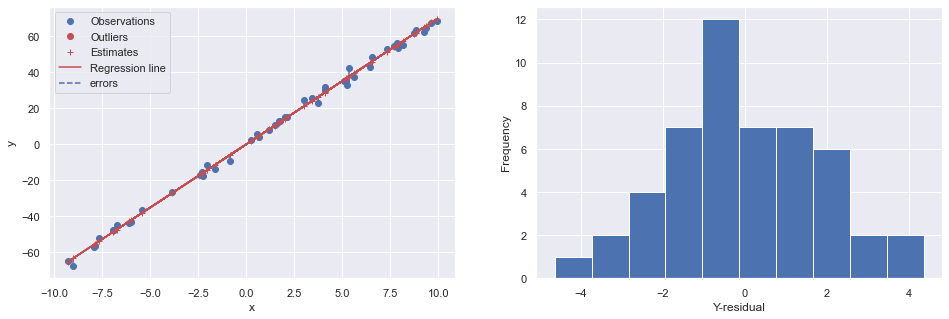

In [37]:
#generate data  
data = generate_data(1, [-10], [10], 0, 2, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data)

#Model Evaluation
mean, sd, RMSE = eval_ols_model(data)

**Model with outliers**


OLS model parameters:
Intercept: -0.50859, Intercept SE: 4.21073
x1 coef: 8.99364, x1 coef SE: 0.70884

Model Evaluation: 
Y-residual Mean: 0.0, Y-residual SD: 28.67, Root Mean Squared Error: 28.382


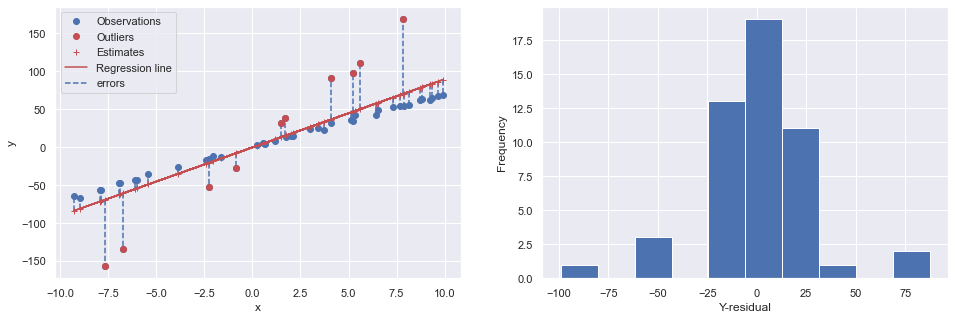

In [38]:
#data_out = scale_datapoints_variable(data, 20, 1, 4)
data_out = scale_datapoints(data.copy(), 20, 3) # use this to ensure results can be reproduced 

#fit using OLS model
result_out = sm.ols(formula='y ~ x1', data=data_out).fit()
print_OLS_result(result_out)

#calculate estimated and residual values
data_out['y_est'] = calculate_y_est(data_out, result_out)
data_out['residuals'] = data_out['y_est'] - data_out['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data_out)

#Model Evaluation
mean_o, sd_o, RMSE_o = eval_ols_model(data_out)

### Using Influence plots

**The leverage vs. Normalized residuals squared plot can be used to identify potentials outliers in a data model. The top right quadrant of the graph identifies points with high leverage and high residuals.**

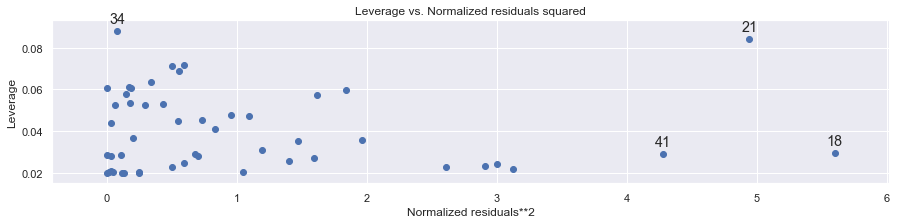

In [39]:
fig, ax = plt.subplots(figsize=(15,3))
fig = plot_leverage_resid2(result, ax=ax)

**The influence plot below can also be used to identify outliers. Here, the leverage of each datapoint is plotted against a different statistic, the studentized residuals. Just as the previous, we focus on finding points with high leverage and high residuals.**

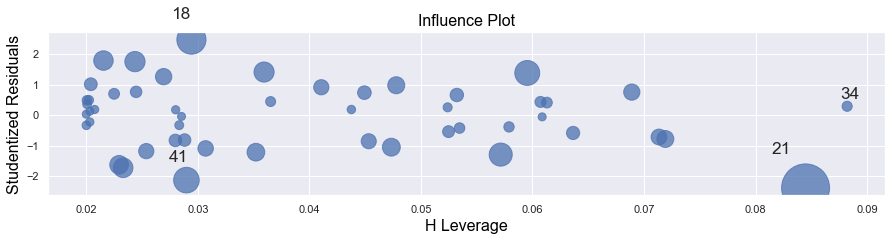

In [40]:
fig, ax = plt.subplots(figsize=(15,3))
fig = influence_plot(result, ax=ax)

### Using Y-residual Plots 

**The Y-residual plots can be examined to find any outliers in the noise variable. In this instance, the noise variable injected into the model follows a normal distribution**

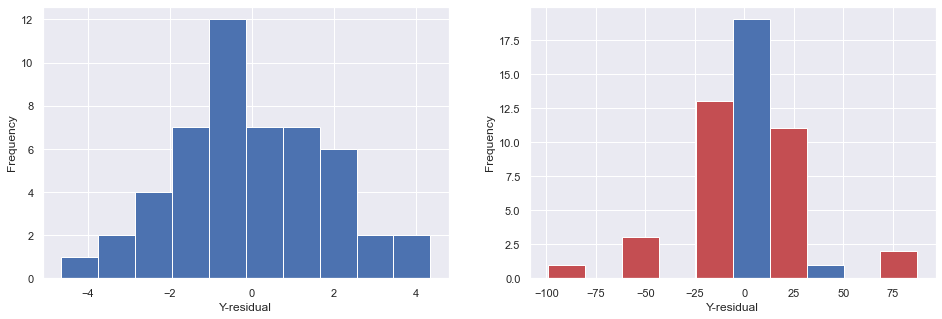

In [41]:
fig = plt.figure(figsize=(16,5))  
ax1 = fig.add_subplot(121) 
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')

ax2 = fig.add_subplot(122) 
n, bins, patches = plt.hist(data_out.residuals)
patches[0].set_fc('r')
patches[1].set_fc('r')
patches[2].set_fc('r')
patches[4].set_fc('r')
patches[6].set_fc('r')
patches[9].set_fc('r')

plt.xlabel('Y-residual')
plt.ylabel('Frequency')
None

### Using Fitted-vs-Residual  Plots 

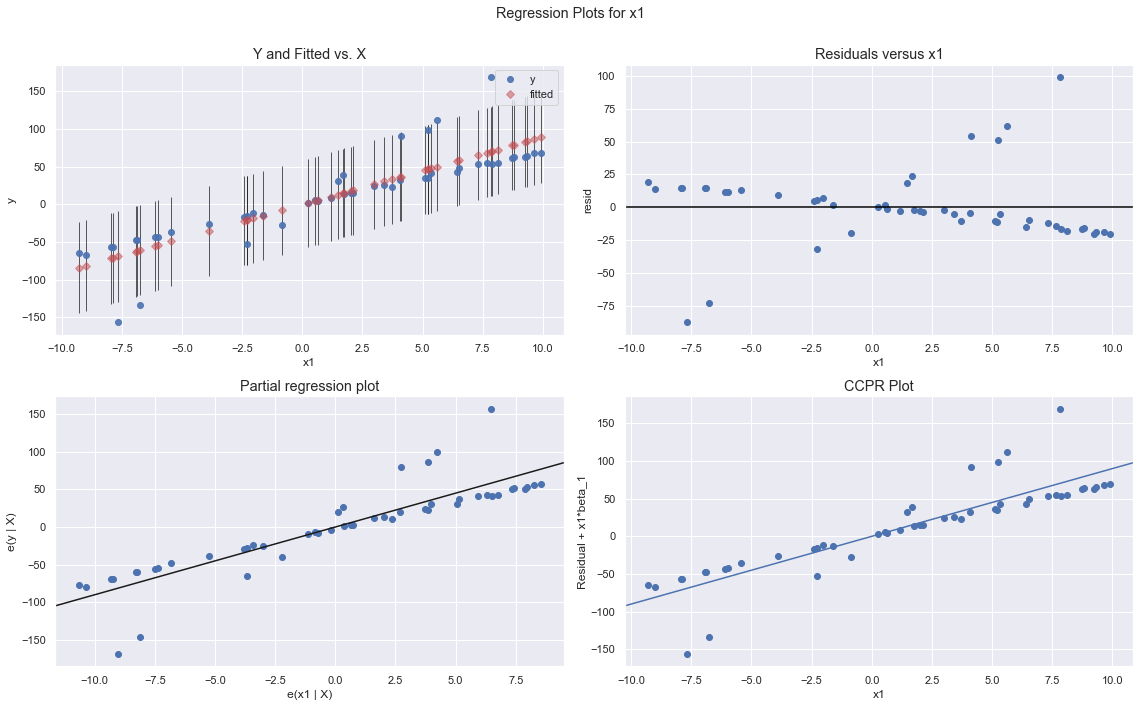

In [42]:
fig = plt.figure(figsize=(16,10))
fig = plot_regress_exog(result_out, "x1", fig = fig)

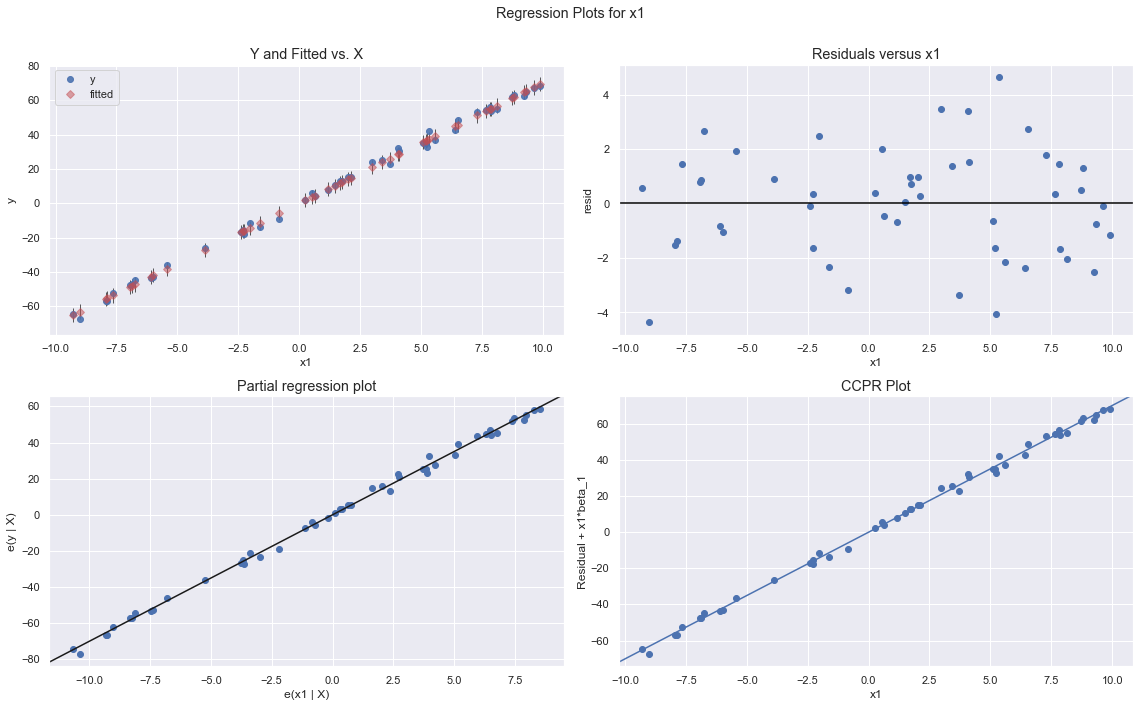

In [43]:
fig = plt.figure(figsize=(16,10))
fig = plot_regress_exog(result, "x1", fig = fig)

### discuss findings
violates assumptions of constant avariance and linearity

**By removing each of the identified outliers, we note that there is an improvement of the slope parameter estimation as well as the model's RMSE**

In [44]:
stats_df = pd.DataFrame(columns = ['a_est', 'a_est_sd', 'rmse']) 
new_result = {'a_est': result_out.params[1], 'a_est_sd': result_out.bse[1], 'rmse': get_RMSE(data_out.y_est, data_out.y)}
stats_df = stats_df.append(new_result, ignore_index = True)

outliers = data_out[data_out.point=='Outlier'].index 

for outlier in outliers:
    data_out = data_out.drop(outlier)
    model = sm.ols(formula='y ~ x1', data=data_out).fit()
    
    #calculate estimated and residual values
    data_out['y_est'] = calculate_y_est(data_out, model)
    data_out['residuals'] = data_out['y_est'] - data_out['y']
    
    new_result = {'a_est': model.params[1], 'a_est_sd': model.bse[1], 'rmse': get_RMSE(data_out.y_est, data_out.y)}
    stats_df = stats_df.append(new_result, ignore_index = True)
    
#stats_df

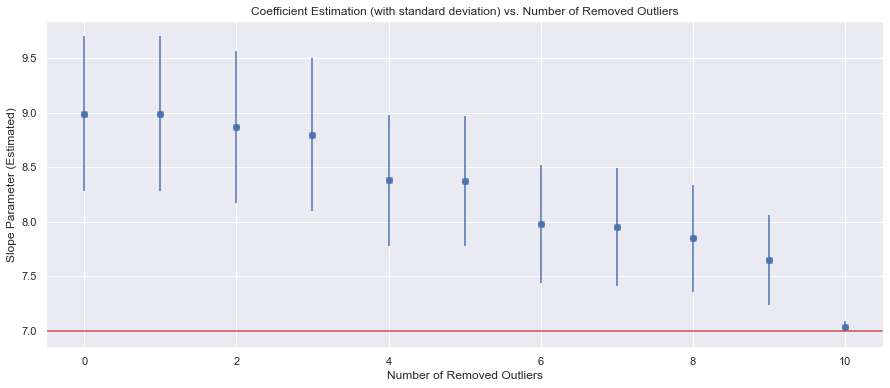

In [45]:
fig = plt.figure(figsize=(15,6))
plt.scatter(stats_df.index, stats_df.a_est)
plt.errorbar(stats_df.index, stats_df.a_est, yerr=stats_df.a_est_sd, fmt="x")
plt.axhline(y=LINE_PARAMETERS[0], color='r', linestyle='-')
plt.title('Coefficient Estimation (with standard deviation) vs. Number of Removed Outliers')
plt.xlabel('Number of Removed Outliers')
plt.ylabel('Slope Parameter (Estimated)')

None

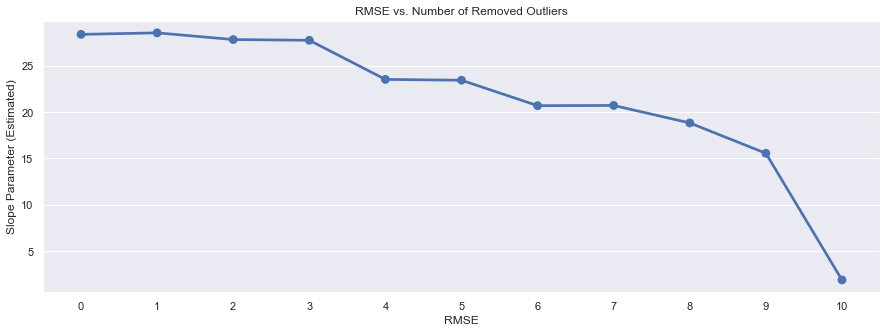

In [46]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
ax = sns.pointplot(x="index", y="rmse", data=stats_df.reset_index())
ax.set_title('RMSE vs. Number of Removed Outliers')
plt.xlabel('RMSE')
plt.ylabel('Slope Parameter (Estimated)')
None

## Effect of outliers on normalization of covariates


OLS model parameters:
Intercept: 26.02994, Intercept SE: 34.01226
x1 coef: 9.78238, x1 coef SE: 1.08578
x2 coef: 0.00526, x2 coef SE: 0.2183
x3 coef: -0.35436, x3 coef SE: 0.433

Model Evaluation: 
Y-residual Mean: 0.0, Y-residual SD: 42.958, Root Mean Squared Error: 42.527


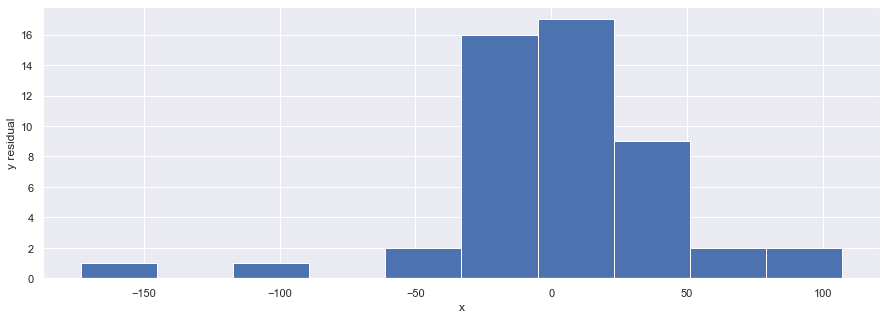

In [47]:
#generate data  
data = generate_data(3, [-10, -50, 50], [10, 50, 100], 0, 10, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

data = scale_datapoints(data.copy(), 20, 4) # use this to ensure results can be reproduced 

#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#Model Evaluation
mean, sd, RMSE = eval_ols_model(data)

#plot y-residuals 
sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data.residuals)
plt.xlabel('x')
plt.ylabel('y residual')
None



OLS model parameters:
Intercept: 0.14046, Intercept SE: 0.20145
x1 coef: 7.97352, x1 coef SE: 0.73456
x2 coef: -0.06931, x2 coef SE: 0.13102
x3 coef: -0.17399, x3 coef SE: 0.25629

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 0.276, Root Mean Squared Error: 0.274


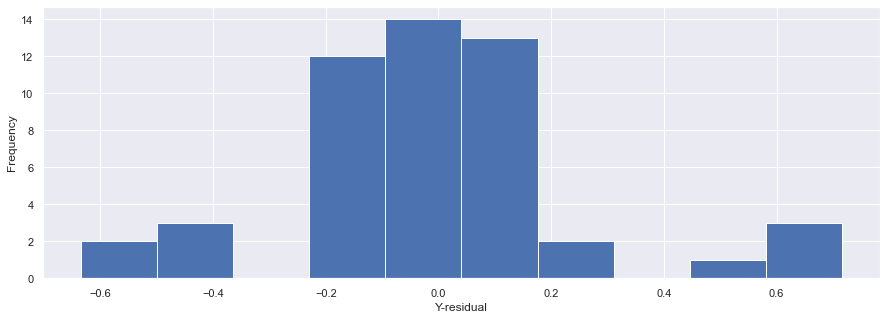

In [48]:
data_out = data.copy()

transformer = Normalizer()
data_trans = transformer.fit_transform(data_out[['x1','x2','x3', 'y']]) 
data_scaled = pd.DataFrame({'x1': data_trans.T[0], 'x2': data_trans.T[1], 'x3' : data_trans.T[2], 'y':data_trans.T[3] })

#fit using OLS model
result_out = sm.ols(formula='y ~ x1 + x2 + x3', data=data_scaled).fit()
print_OLS_result(result_out)

#calculate estimated and residual values
data_scaled['y_est'] = calculate_y_est(data_scaled, result_out)
data_scaled['residuals'] = data_scaled['y_est'] - data_scaled['y']


#Model Evaluation
mean, sd, RMSE = eval_ols_model(data_scaled)

#plot y-residuals 

sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data_scaled.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')
None

## add explanation -----------------------------------------------------------------------------------------------------

In [49]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     27.50
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           2.44e-10
Time:                        19:34:21   Log-Likelihood:                -258.45
No. Observations:                  50   AIC:                             524.9
Df Residuals:                      46   BIC:                             532.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.0299     34.012      0.765      0.448     -42.433      94.493
x1             9.7824      1.086      9.010      0.000       7.597      11.968
x2             0.0053      0.218      0.024      0.981      -0.434       0.445
x3            -0.3544      0.433     -0.818      0.417      -1.226       0.517
==============================================================================
Omnibus:                       21.324   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.658
Skew:                           1.034   Prob(JB):                     4.98e-13
Kurtosis:                       7.787   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""